In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [73]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
import albumentations as A
from albumentations.pytorch import ToTensorV2

## DATASET

In [184]:
class KeypointsDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform):
        self.annotation = pd.read_csv(csv_file).dropna(axis=0, how='any')
        self.annotation = self.annotation.reset_index(drop=True)
        print(len(self.annotation))
        self.transform = transform
       
    def __len__(self):
        return len(self.annotation)
    
    def __getitem__(self, index):
        img = self.annotation.iloc[index]["Image"]
        image = np.array(img.split()).reshape(96, 96)
        ## transform
        image = np.repeat(image.reshape(96,96,1),3,2).astype(np.uint8)
        keypoints = self.annotation.iloc[index].to_numpy()[:-1].reshape(-1,2)
        augmentations = self.transform(image=image, keypoints=keypoints)
        image = augmentations["image"]
        keypoints = np.array(augmentations["keypoints"]).reshape(-1)
        # plt.imshow(image.permute(1,2,0), cmap="gray")
        # plt.scatter(keypoints.reshape(15,2)[:,0], keypoints.reshape(15,2)[:,1], c="white")
        return image, keypoints
    
    def __show_img_annotated__(self, index):
        img = self.annotation.iloc[index]["Image"]
        image = np.array(img.split()).astype(np.uint8).reshape(96, 96)
        #image = Image.fromarray(image, 'L')
        plt.imshow(image, cmap="gray")
        keypoints = self.annotation.iloc[index].to_numpy()[:-1].reshape(-1,2)
        plt.scatter(keypoints[:,0], keypoints[:,1], c="white")
        plt.show()

In [185]:
transform = A.Compose([
    A.Resize(width=96, height=96),
    A.Rotate(limit=40, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.9),
    A.OneOf([A.Blur(blur_limit=3, p=0.5), A.ColorJitter(p=0.5),], p=1.0),
    ToTensorV2(),
    ],keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),

)

In [186]:
dataset = KeypointsDataset("training/training.csv", transform)

2140


In [187]:
dataset.__getitem__(90)

(tensor([[[216, 216, 216,  ..., 206, 206, 208],
          [216, 216, 216,  ..., 206, 205, 206],
          [216, 216, 216,  ..., 204, 205, 205],
          ...,
          [ 71,  80,  99,  ..., 183, 183, 182],
          [ 71,  88, 108,  ..., 184, 182, 181],
          [ 80,  76,  96,  ..., 181, 184, 183]],
 
         [[198, 199, 199,  ..., 178, 179, 180],
          [199, 199, 199,  ..., 179, 176, 179],
          [199, 199, 199,  ..., 175, 176, 176],
          ...,
          [ 42,  51,  71,  ..., 154, 154, 154],
          [ 42,  60,  80,  ..., 155, 154, 153],
          [ 51,  47,  67,  ..., 153, 155, 154]],
 
         [[196, 197, 197,  ..., 180, 181, 183],
          [197, 197, 197,  ..., 181, 179, 181],
          [197, 197, 197,  ..., 179, 179, 179],
          ...,
          [ 45,  54,  74,  ..., 158, 158, 157],
          [ 45,  63,  83,  ..., 158, 157, 156],
          [ 54,  51,  71,  ..., 156, 158, 158]]], dtype=torch.uint8),
 array([30.55413333, 38.26432   , 62.3344    , 36.99313778, 35.

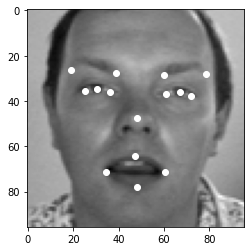

In [188]:
dataset.__show_img_annotated__(590)

In [189]:
dataset.__len__()

2140

In [190]:
## split data
train_size = int(np.floor(len(dataset)*0.8))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [191]:
train_data

(tensor([[[137, 123, 109,  ..., 115, 134, 139],
          [158, 147, 133,  ..., 109, 130, 154],
          [173, 157, 141,  ..., 106, 122, 155],
          ...,
          [180, 181, 183,  ..., 219, 220, 218],
          [179, 184, 180,  ..., 217, 219, 217],
          [180, 179, 179,  ..., 221, 218, 218]],
 
         [[137, 123, 109,  ..., 115, 134, 139],
          [158, 147, 133,  ..., 109, 130, 154],
          [173, 157, 141,  ..., 106, 122, 155],
          ...,
          [180, 181, 183,  ..., 219, 220, 218],
          [179, 184, 180,  ..., 217, 219, 217],
          [180, 179, 179,  ..., 221, 218, 218]],
 
         [[137, 123, 109,  ..., 115, 134, 139],
          [158, 147, 133,  ..., 109, 130, 154],
          [173, 157, 141,  ..., 106, 122, 155],
          ...,
          [180, 181, 183,  ..., 219, 220, 218],
          [179, 184, 180,  ..., 217, 219, 217],
          [180, 179, 179,  ..., 221, 218, 218]]], dtype=torch.uint8),
 array([69.81473684, 39.888     , 30.29894737, 37.25389474, 61.

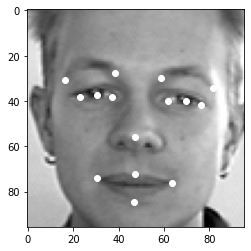

In [136]:
train_data.__getitem__(50)

## Model : efficientNet

In [137]:
from efficientnet_pytorch import EfficientNet

In [138]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [139]:
model = EfficientNet.from_pretrained('efficientnet-b0')
#for param in model.parameters():
#    param.requires_grad = False
model._fc = nn.Sequential(nn.Linear(1280, 30))
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [140]:
model(torch.randn(1,3,96,96).to(device))

tensor([[-6.2687e-02,  3.8533e-02, -1.8326e-02,  5.6064e-02, -1.6122e-01,
         -5.5904e-02,  1.2539e-01,  8.2891e-02, -4.4131e-02,  1.0518e-01,
         -7.9385e-02,  8.2468e-02, -1.3411e-02,  8.3076e-02, -1.4625e-01,
          1.0816e-01,  6.8785e-02,  4.6455e-02,  2.7992e-05,  7.3054e-02,
         -9.0856e-02,  3.4861e-03,  1.5499e-01, -5.4235e-02, -1.8195e-01,
          1.4809e-01,  1.5369e-02, -1.2181e-01,  1.5416e-02,  9.3706e-02]],
       device='cuda:0', grad_fn=<AddmmBackward>)

## Training

In [141]:
## hyperparameters
EPOCH = 10
LR = 1e-5
BATCH_SIZE = 16
loss_function = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [142]:
device

'cuda'

In [143]:
train_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, shuffle=True)

In [197]:
def train(model):
    for epoch in range(200):
        losses = []
        num_examples = 0
        for batch in tqdm(train_loader):
            X_batch ,Y_batch = batch[0].view(-1,3,96,96).to(device), batch[1].to(device)
            plt.imshow(batch[0][0].permute(1,2,0), cmap="gray")
            plt.scatter(batch[1][0].reshape(15,2)[:,0], batch[1][0].reshape(15,2)[:,1], c="white")
            output = model(X_batch.float())
            loss = loss_function(output, Y_batch.float())
            num_examples += torch.numel(Y_batch)
            losses.append(loss)
            model.zero_grad()
            loss.backward()
            optimizer.step()
           
        print(f"Loss at epoch {epoch} is {(sum(losses)/num_examples)**0.5}")


In [ ]:
train(model)

  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 0 is 27.180444717407227


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 1 is 26.781036376953125


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 2 is 26.366487503051758


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 3 is 26.014135360717773


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 4 is 25.625394821166992


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 5 is 25.281389236450195


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 6 is 24.857959747314453


  0%|                                                                                          | 0/107 [00:00<?, ?it/s]

Loss at epoch 7 is 24.496179580688477


 36%|████████████████████████████▊                                                    | 38/107 [00:13<00:23,  2.97it/s]

In [192]:
test_loader = torch.utils.data.DataLoader(train_data, 1, shuffle=True)

(1, 30)
[[27.63491  27.323889]
 [27.45673  27.358013]
 [27.617622 27.067963]
 [27.536015 27.120209]
 [27.952177 27.412184]
 [27.333815 27.279127]
 [28.015888 26.157375]
 [26.66212  25.580076]
 [28.000914 26.03855 ]
 [26.719381 25.84931 ]
 [28.29159  28.817326]
 [28.102314 29.002712]
 [27.38309  29.08855 ]
 [28.177235 29.202202]
 [27.990488 29.657911]]


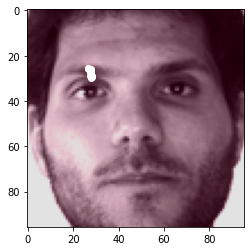

In [196]:
for batch in test_loader:
    X_batch ,Y_batch = batch[0].view(-1,3,96,96).to(device), batch[1].to(device)
    output = model(X_batch.float()).cpu().detach().numpy()
    print(np.shape(output))
    plt.imshow(X_batch.cpu()[0].permute(1,2,0), cmap="gray")
    keypoints = output.reshape(-1,2)
    print(keypoints)
    
    plt.scatter(keypoints[:,0], keypoints[:,1], c="white")
    plt.show()
    break

In [170]:
[[46.772194 39.341957]
 [46.582127 39.248917]
 [46.900356 39.779953]
 [46.21342  39.780144]
 [46.859016 39.527134]
 [46.39217  39.943947]
 [47.221252 33.213497]
 [45.772232 33.702396]
 [46.83389  33.250404]
 [45.64743  33.988945]
 [47.281296 52.970276]
 [46.779633 59.20222 ]
 [46.747066 59.274265]
 [47.218983 58.2278  ]
 [46.898457 59.637024]]

SyntaxError: invalid syntax (<ipython-input-170-a7b9d598b0bc>, line 1)

In [48]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [49]:
checkpoint = {"state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
             }
save_checkpoint(checkpoint, filename="checkpoint_keypoint")

=> Saving checkpoint


In [50]:
load_checkpoint("checkpoint_keypoint" ,model, optimizer)

=> Loading checkpoint


TypeError: string indices must be integers